# Make a timeseries of GOES ABI observations for a single point

This notebook demonstrates the `goes_ortho.make_abi_timeseries()` function to create a timeseries of a GOES ABI product variable (or variables) from a collection of GOES ABI products (netcdf files).

---

First, import the goes_ortho functions, as well as pandas and matplotlib for plotting.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import goes_ortho

---

The location I'm going to look at is the Gaylor Pit snow study plot in Yosemite National Park, in California's Sierra Nevada. This study plot is along Hwy 120 in Tuolumne Meadows.

![GaylorPit_site_2017_2018_small.jpeg](GaylorPit_site_2017_2018_small.jpeg)

We have measurements of snow surface temperature from this study site (column name "TT_C [Deg C]"). I'll load those here from a csv file. I'll also switch over to temperature in K and time in UTC to match the GOES ABI temperature data.

In [2]:
ground_data = pd.read_csv("GaylorPit_039_T15min.csv", comment="#", delimiter="\t")
# create a pandas timestamp for the dataframe index, convert PST to UTC by adding 8 hours
ground_data["timestamp"] = pd.to_datetime(ground_data["TIMESTAMP [TS]"]) + pd.Timedelta(
    hours=8
)
ground_data.set_index("timestamp", inplace=True)
# create a column for snow surface tempeature in K
ground_data["Tss [K]"] = ground_data["TT_C [Deg C]"] + 273.15
# preview the first row of data
ground_data.head(1)

,TIMESTAMP [TS],RECORD [RN],BattV [Volts],PTemp_C [Deg C],TT_C [Deg C],SBT_C [Deg C],Judd_Air_TempF [Deg F],Judd_Depth [Inches],SlrkW_up [kW/m^2],SlrkW_dwn [kW/m^2],WindSpeed [mph],WindDirection [deg],Tss [K]
timestamp,,,,,,,,,,,,,
2017-11-13 22:00:00,11/13/2017 14:00,0,13.47,11.33,20.81,7.917,47.85,0.406,NAN,0.0,NAN,0,293.96


---

I will need the location in degrees longitude, latitude, and elevation in meters for this site:

(elevation in meters is to correct for the parallax effect over terrain that is much higher than the base GRS80 ellipsoid that the GOES ABI products are projected with)

In [3]:
lon = -119.31212
lat = 37.88175
z = 2811  # elevation in meters

Take a look at the help info for the `goes_ortho.make_abi_timeseries()` function, showing what arguments I need to provide:

In [4]:
help(goes_ortho.make_abi_timeseries)

Help on function make_abi_timeseries in module goes_ortho:

make_abi_timeseries(directory, product, data_vars, lon, lat, z, outfilepath=None)
    Given a directory of GOES ABI products, create a timeseries of data variables (specified in data_vars) for a single point (at lon, lat, elevation).
    Returns a pandas dataframe, optional output to a csv file.



Use this function to make a timeseries of the cloud mask product, binary cloud mask (BCM) and data quality flag (DQF) variables. Also export the resulting pandas dataframe to a csv file.

In [5]:
ACM = goes_ortho.make_abi_timeseries(
    "/storage/GOES/goes16/2018/4/",
    "ACMC",
    ["BCM", "DQF"],
    lon,
    lat,
    z,
    "./GOES-16_ABI-L2-ACMC_Tuolumne_April2018.csv",
)

Creating a timeseries of ['BCM', 'DQF'] from ACMC at (37.88175, -119.31212, 2811)
Reading:
Saving csv file to: ./GOES-16_ABI-L2-ACMC_Tuolumne_April2018.csvG16_s20181202357214_e20181202359587_c20181210000194.nc


Make a timeseries of the Radiance product for ABI channel 14. Note that we can use `*` as a wildcard in specifying the product name. Because this is a radiance product, `make_abi_timeseries()` will also generate a reflectance (for bands 1-6) or brightness temperature (for bands 7-16) column in the resulting dataframe (`ref_or_tb`). Again, also export this to a csv file.

In [6]:
Rad = goes_ortho.make_abi_timeseries(
    "/storage/GOES/goes16/2018/04/",
    "RadC-*C14*",
    ["Rad"],
    lon,
    lat,
    z,
    "./GOES-16_ABI-L1b-Radc_Tuolumne_April2018.csv",
)

Creating a timeseries of ['Rad'] from RadC-*C14* at (37.88175, -119.31212, 2811)
Reading:
Saving csv file to: ./GOES-16_ABI-L1b-Radc_Tuolumne_April2018.csvdC-M3C14_G16_s20181202357214_e20181202359587_c20181210000030.nc


Make a timeseries of the land surface temperature product here. Again, also export this to a csv file.

In [7]:
LST = goes_ortho.make_abi_timeseries(
    "/storage/GOES/goes16/2018/4/",
    "LSTC",
    ["LST"],
    lon,
    lat,
    z,
    "./GOES-16_ABI-L2-LSTC_Tuolumne_April2018.csv",
)

Creating a timeseries of ['LST'] from LSTC at (37.88175, -119.31212, 2811)
Reading:
Saving csv file to: ./GOES-16_ABI-L2-LSTC_Tuolumne_April2018.csvG16_s20181202302214_e20181202304586_c20181202306162.nc


---

Plot the timeseries of all three products together with the ground-based measurements of snow surface temperature to compare band 14 brightness temperature, land surface temperature, and the cloud mask.

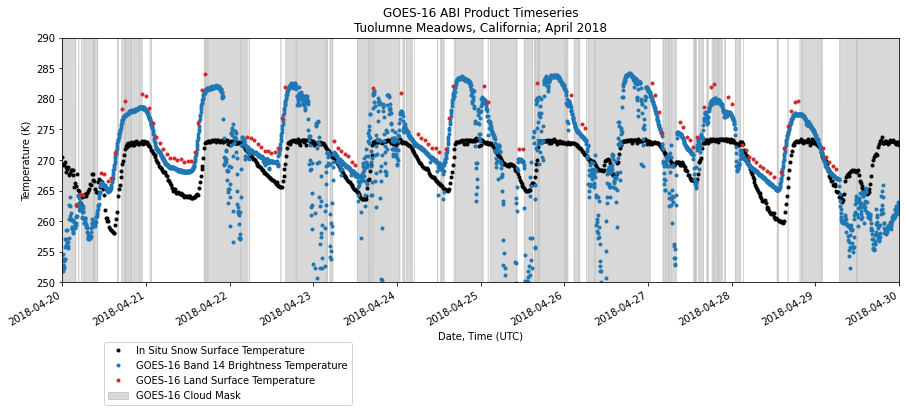

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

# specify axes limits
startdate, enddate = pd.Timestamp(2018, 4, 20), pd.Timestamp(2018, 4, 30)
ymin, ymax = 250, 290  # axes limits in K

ground_data["Tss [K]"].plot(
    ax=ax,
    color="k",
    linestyle="none",
    marker=".",
    label="In Situ Snow Surface Temperature",
)

# plot brightness temperature from the RadC channel 14 product
Rad.ref_or_tb.plot(
    ax=ax,
    color="tab:blue",
    linestyle="none",
    marker=".",
    label="GOES-16 Band 14 Brightness Temperature",
)

# plot land surface temperature
LST.LST.plot(
    ax=ax,
    color="tab:red",
    linestyle="none",
    marker=".",
    label="GOES-16 Land Surface Temperature",
)

# plot the cloud mask (this is a binary, 0 or 1), multiply by ymax on the temperature scale so that it spans the plot vertically
ax.fill_between(
    ACM.index,
    y1=ACM.BCM * ymax,
    color="grey",
    alpha=0.3,
    label="GOES-16 Cloud Mask",
    zorder=0,
)

# set up x axis
ax.set_xlim(startdate, enddate)
ax.set_xlabel("Date, Time (UTC)")

# set up y axis
ax.set_ylim((ymin, ymax))
ax.set_ylabel("Temperature (K)")

# add legend to the plot
plt.legend(loc=(0.05, -0.5))

# add a title to the plot
plt.title("GOES-16 ABI Product Timeseries\nTuolumne Meadows, California; April 2018");